In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import os
import json
import time

# Set paths to your dataset
train_dir = '/kaggle/input/traffic-datset-with-label/Train'
test_dir = '/kaggle/input/traffic-datset-with-label/Test'

# Load datasets
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int'  # Class labels will be integers (0-3)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int'
)

# Optional: Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Class names
class_names = sorted(os.listdir(train_dir))

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Number of classes
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
EPOCHS = 10
start_time = time.time()
history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS)
training_time = time.time() - start_time

# Evaluate model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')

# Predict on test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# ROC curve and AUC calculation
true_labels_one_hot = label_binarize(true_labels, classes=range(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Average AUC for all classes (macro-average)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Prepare results for JSON
results = {
    "accuracy": accuracy * 100,
    "training_time": training_time,
    "epochs": EPOCHS,
    "final_model_history": {
        "accuracy": history.history['accuracy'],
        "loss": history.history['loss'],
        "val_accuracy": history.history['val_accuracy'],
        "val_loss": history.history['val_loss']
    },
    "class_names": class_names,
    "image_size": IMG_SIZE,
    "confusion_matrix": confusion_mat.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save results to JSON file
json_file_path = '/kaggle/working/CNN_Results_128.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f'Results saved to {json_file_path}')


Found 2390 files belonging to 4 classes.
Found 600 files belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.3557 - loss: 20.3385 - val_accuracy: 0.2983 - val_loss: 1.3382
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4046 - loss: 1.2703 - val_accuracy: 0.3017 - val_loss: 1.3207
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4964 - loss: 1.1472 - val_accuracy: 0.3350 - val_loss: 1.3548
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5125 - loss: 1.0731 - val_accuracy: 0.3617 - val_loss: 1.4022
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5541 - loss: 1.0189 - val_accuracy: 0.3133 - val_loss: 1.3796
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5555 - loss: 0.9982 - val_accuracy: 0.3883 - val_loss: 1.5288
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6130 - loss: 0.8918 - val_accuracy: 0.4050 - val_loss: 1.5306
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6842 - loss: 0.7604 - val_accuracy: 0.3800 - val_loss:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import os
import json
import time

# Set paths to your dataset
train_dir = '/kaggle/input/traffic-datset-with-label/Train'
test_dir = '/kaggle/input/traffic-datset-with-label/Test'

# Load datasets
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int'  # Class labels will be integers (0-3)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int'
)

# Optional: Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Extract class names
class_names = sorted(os.listdir(train_dir))

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Number of classes
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
EPOCHS = 10
start_time = time.time()
history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS)
training_time = time.time() - start_time

# Evaluate model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')

# Predict on test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# ROC curve and AUC calculation
true_labels_one_hot = label_binarize(true_labels, classes=range(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Average AUC for all classes (macro-average)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Prepare results for JSON
results = {
    "accuracy": accuracy * 100,
    "training_time": training_time,
    "epochs": EPOCHS,
    "final_model_history": {
        "accuracy": history.history['accuracy'],
        "loss": history.history['loss'],
        "val_accuracy": history.history['val_accuracy'],
        "val_loss": history.history['val_loss']
    },
    "class_names": class_names,
    "image_size": IMG_SIZE,
    "confusion_matrix": confusion_mat.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save results to JSON file
json_file_path = '/kaggle/working/CNN_Results_256.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f'Results saved to {json_file_path}')


Found 2390 files belonging to 4 classes.
Found 600 files belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.3210 - loss: 129.1982 - val_accuracy: 0.3400 - val_loss: 1.3375
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4586 - loss: 1.2440 - val_accuracy: 0.3867 - val_loss: 1.3699
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5753 - loss: 1.0407 - val_accuracy: 0.3917 - val_loss: 1.4290
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6548 - loss: 0.9068 - val_accuracy: 0.3767 - val_loss: 1.4492
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6894 - loss: 0.8170 - val_accuracy: 0.3783 - val_loss: 1.5227
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7415 - loss: 0.7607 - val_accuracy: 0.3933 - val_loss: 1.9216
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7211 - loss: 0.7647 - val_accuracy: 0.3917 - val_loss: 2.2225
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7590 - loss: 0.6406 - val_accuracy: 0.3767 - val_loss

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import os
import json
import time

# Set paths to your dataset
train_dir = '/kaggle/input/traffic-datset-with-label/Train'
test_dir = '/kaggle/input/traffic-datset-with-label/Test'

# Load datasets
IMG_SIZE = (512, 512)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int'  # Class labels will be integers (0-3)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int'
)

# Optional: Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Extract class names
class_names = sorted(os.listdir(train_dir))

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Number of classes
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
EPOCHS = 10
start_time = time.time()
history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS)
training_time = time.time() - start_time

# Evaluate model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')

# Predict on test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# ROC curve and AUC calculation
true_labels_one_hot = label_binarize(true_labels, classes=range(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Average AUC for all classes (macro-average)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Prepare results for JSON
results = {
    "accuracy": accuracy * 100,
    "training_time": training_time,
    "epochs": EPOCHS,
    "final_model_history": {
        "accuracy": history.history['accuracy'],
        "loss": history.history['loss'],
        "val_accuracy": history.history['val_accuracy'],
        "val_loss": history.history['val_loss']
    },
    "class_names": class_names,
    "image_size": IMG_SIZE,
    "confusion_matrix": confusion_mat.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save results to JSON file
json_file_path = '/kaggle/working/CNN_Results_512.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f'Results saved to {json_file_path}')


Found 2390 files belonging to 4 classes.
Found 600 files belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 480ms/step - accuracy: 0.3282 - loss: 192.3336 - val_accuracy: 0.2717 - val_loss: 1.3338
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.4608 - loss: 1.2112 - val_accuracy: 0.3467 - val_loss: 1.5197
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.6333 - loss: 0.9449 - val_accuracy: 0.3733 - val_loss: 1.5065
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.6989 - loss: 0.7920 - val_accuracy: 0.3683 - val_loss: 1.8202
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.7399 - loss: 0.6942 - val_accuracy: 0.3633 - val_loss: 2.6190
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.8262 - loss: 0.5058 - val_accuracy: 0.3817 - val_loss: 3.2399
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.8507 - loss: 0.4571 - val_accuracy: 0.3717 - val_loss: 3.6670
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9231 - loss: 0.2527 - val_accuracy: 0.3717 - v

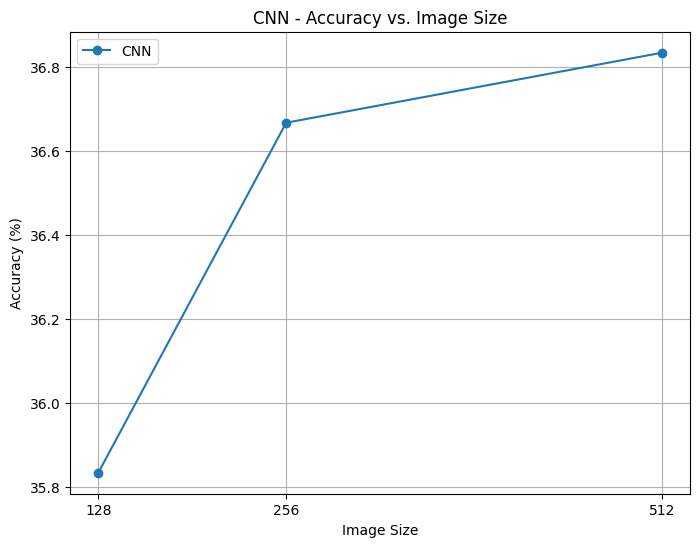

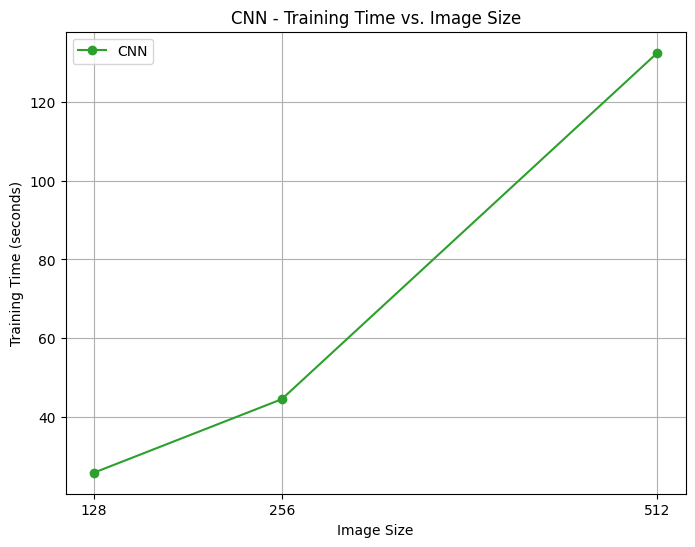

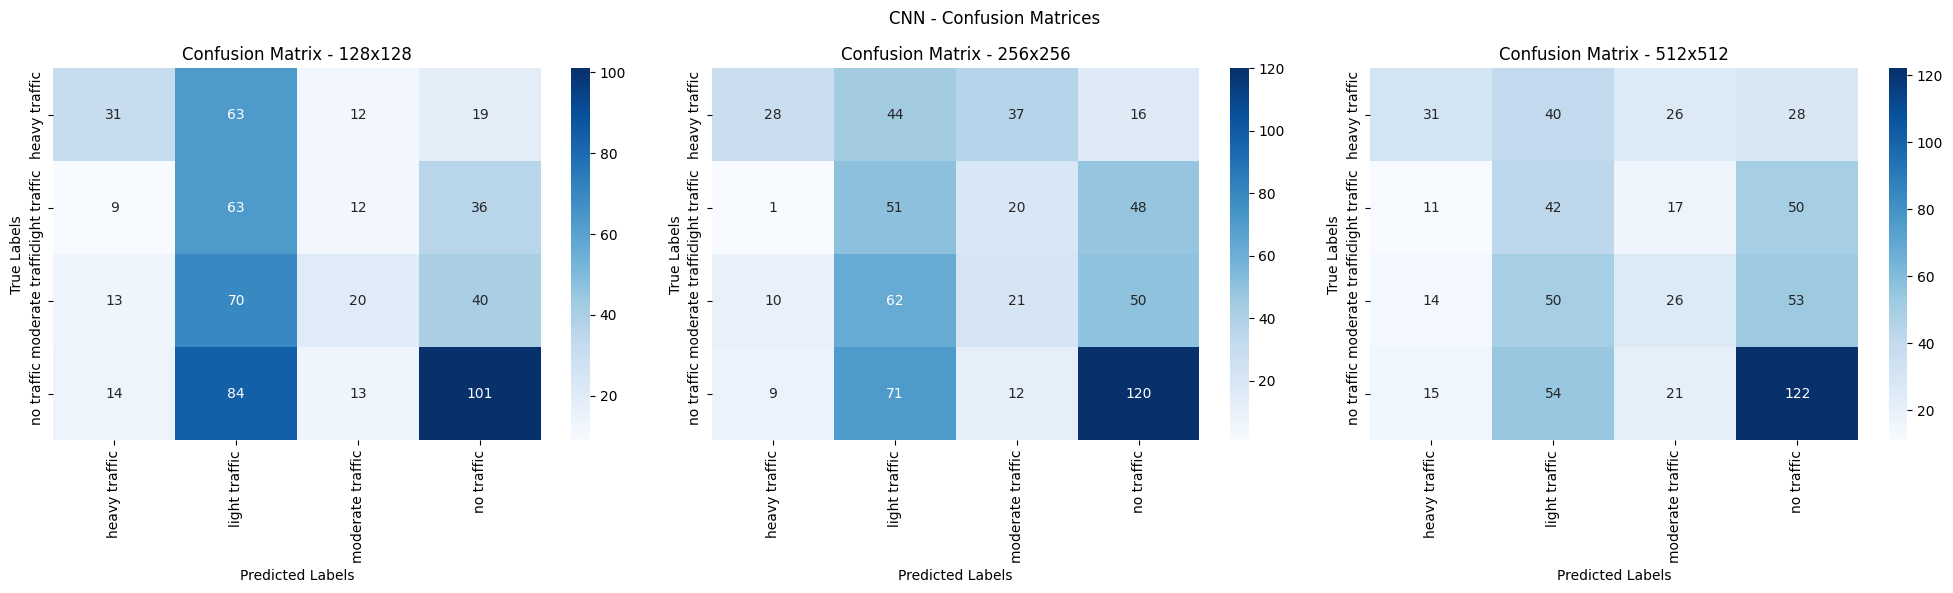

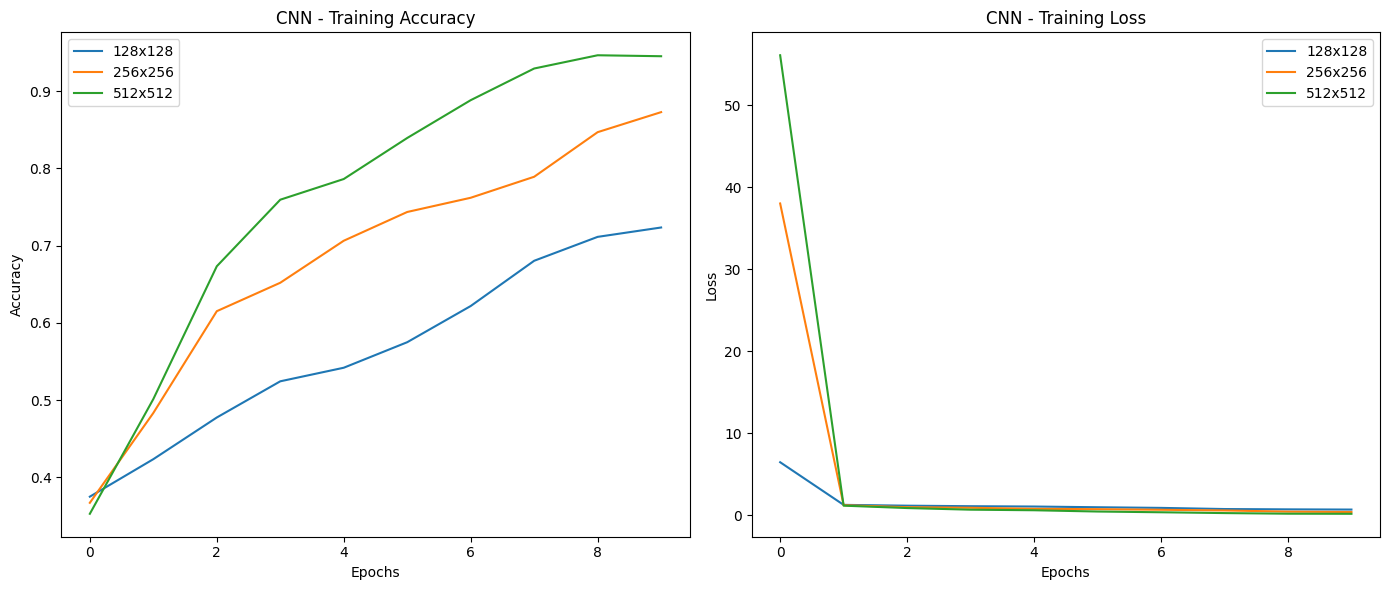

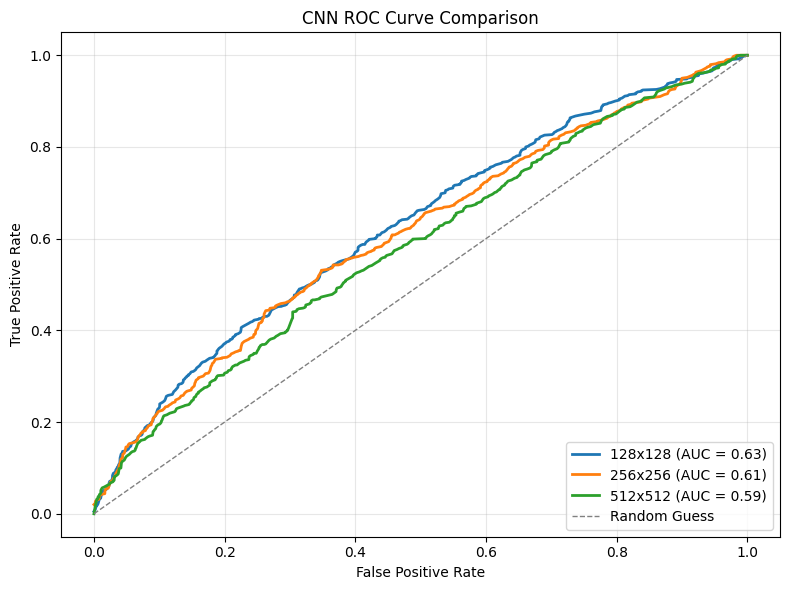

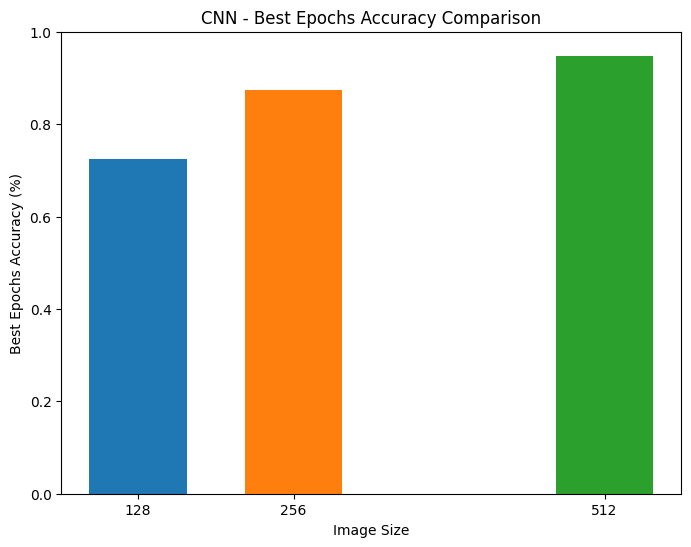

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.ticker as ticker

# Load the three JSON files
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Paths to the JSON files
json_files = [
    '/kaggle/working/CNN_Results_128.json',
    '/kaggle/working/CNN_Results_256.json',
    '/kaggle/working/CNN_Results_512.json'
]

# Load results for each image size
results_128 = load_json(json_files[0])
results_256 = load_json(json_files[1])
results_512 = load_json(json_files[2])

# Image sizes for x-axis
image_sizes = [128, 256, 512]

# Accuracy and Training Time
accuracy_values = [results_128['accuracy'], results_256['accuracy'], results_512['accuracy']]
training_times = [results_128['training_time'], results_256['training_time'], results_512['training_time']]

# Confusion Matrices
cm_128 = np.array(results_128['confusion_matrix'])
cm_256 = np.array(results_256['confusion_matrix'])
cm_512 = np.array(results_512['confusion_matrix'])

# Final Model Accuracy
final_accuracy = [
    np.max(results_128['final_model_history']['accuracy']),
    np.max(results_256['final_model_history']['accuracy']),
    np.max(results_512['final_model_history']['accuracy'])
]

# Class names
class_names = results_128['class_names']

# Plot 1: Accuracy vs. Image Size
plt.figure(figsize=(8, 6))
plt.plot(image_sizes, accuracy_values, marker='o', color='tab:blue', label='CNN')
plt.title('CNN - Accuracy vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Accuracy (%)')
plt.xticks(image_sizes)
plt.grid(True)
plt.legend()
plt.savefig('CNN_Accuracy_vs_Image_Size.png')
plt.show()

# Plot 2: Training Time vs. Image Size
plt.figure(figsize=(8, 6))
plt.plot(image_sizes, training_times, marker='o', color='tab:green', label='CNN')
plt.title('CNN - Training Time vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Training Time (seconds)')
plt.xticks(image_sizes)
plt.grid(True)
plt.legend()
plt.savefig('CNN_Training_Time_vs_Image_Size.png')
plt.show()

# Plot 3: Confusion Matrices (Side-by-Side Heatmaps)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, cm, size in zip(axes, [cm_128, cm_256, cm_512], image_sizes):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Confusion Matrix - {size}x{size}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
plt.suptitle('CNN - Confusion Matrices')
plt.tight_layout()
plt.savefig('CNN_Confusion_Matrices.png')
plt.show()

# Plot 4: Learning Curves (Accuracy and Loss vs. Epoch)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax[0].plot(results_128['final_model_history']['accuracy'], label='128x128', color='tab:blue')
ax[0].plot(results_256['final_model_history']['accuracy'], label='256x256', color='tab:orange')
ax[0].plot(results_512['final_model_history']['accuracy'], label='512x512', color='tab:green')
ax[0].set_title('CNN - Training Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss
ax[1].plot(results_128['final_model_history']['loss'], label='128x128', color='tab:blue')
ax[1].plot(results_256['final_model_history']['loss'], label='256x256', color='tab:orange')
ax[1].plot(results_512['final_model_history']['loss'], label='512x512', color='tab:green')
ax[1].set_title('CNN - Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.savefig('CNN_Learning_Curves.png')
plt.show()

# Plot 5: ROC Curve
plt.figure(figsize=(8, 6))

# Iterate over image sizes and their results
for size, results, color in zip(
    image_sizes,
    [results_128, results_256, results_512],
    ['tab:blue', 'tab:orange', 'tab:green']
):
    # Safely retrieve 'roc_curve' key
    roc_curve_data = results.get('roc_curve', {})
    fpr = roc_curve_data.get('fpr', [])
    tpr = roc_curve_data.get('tpr', [])
    auc_value = roc_curve_data.get('auc', None)

    if fpr and tpr and auc_value is not None:
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{size}x{size} (AUC = {auc_value:.2f})')
    else:
        print(f"Missing ROC data for image size {size}")

# Add plot details
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('CNN_ROC_Curve.png')
plt.show()

# Plot 6: Best Epochs Accuracy Comparison
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
bars = plt.bar(image_sizes, final_accuracy, color=colors, width=80)
plt.title('CNN - Best Epochs Accuracy Comparison')
plt.xlabel('Image Size')
plt.ylabel('Best Epochs Accuracy (%)')
plt.xticks(image_sizes)
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(image_sizes))
plt.ylim(0, 1)
plt.savefig('CNN_Best_Epochs_Accuracy_Comparison.png')
plt.show()
